In [319]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload
from spectra_manager import CoupledSpectraCreatorTimeResolved, TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator


reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [320]:
import typing as tp

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi),
                                    initial_grid_frequency=12,
                                    interpolate=False)
rotation_matrices = mesh.create_rotation_matrices()

def build_powder(rotation_matrices, *args) -> spin_system.MultiOrientedSample:
        params = args[0] if len(args) == 1 else args
        g_factor, g_strain, D, D_str, E_D_attitude, h_strain = params

        # g-tensor components
        g_tensor = torch.full((3,), g_factor)
        g_frame = torch.zeros(3)
        g_strain_tensor = torch.full((3,), g_strain)

        # Zero-field splitting calculations
        D_val = 2.0 * D * 1e6
        E_val = 2.0 * D * E_D_attitude * 1e6
        #E_val = -2.0 * E * 1e6
        Dz = 2/3 * D_val
        Dx = -1/3 * D_val - E_val
        Dy = -1/3 * D_val + E_val

        # Strain calculations
        E_str = D_str * E_D_attitude
        #E_str = E_str
        Dx_s = -1/3 * D_str - E_str
        Dy_s = -1/3 * D_str + E_str
        Dz_s = 2/3 * D_str
        strain_e_e = torch.tensor([Dx_s, Dy_s, Dz_s]) \
            * (constants.PLANCK / constants.BOHR) * 1e6

        J = 1.1
        J = 2 * J # Because 2 S1 S2
        J_hz = (J * 100) * 3 * 1e8
        
        components_dipole = torch.tensor([Dx, Dy, Dz]) + J_hz
        d_frame = torch.zeros(3)

        # System construction
        zeem = spin_system.Interaction(g_tensor, g_frame, g_strain_tensor)
        ee_int = spin_system.Interaction(components_dipole, d_frame, strain_e_e)

        e1 = particles.Electron(spin=0.5)
        e2 = particles.Electron(spin=0.5)
        system = spin_system.SpinSystem(
            electrons=[e1, e2],
            g_tensors=[zeem, zeem],
            electron_electron=[(0, 1, ee_int)]
        )

        # Homogeneity strain
        hum_str = 3 * h_strain * torch.ones(3)
        hum_str *= (constants.PLANCK / constants.BOHR) * 4e5
        return spin_system.MultiOrientedSample(system, hum_str, rotation_matrices)
    
    
best_params_cw = {'g_factor': 2.0064026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())

powder_1 = build_powder(rotation_matrices, best_values_cw)


best_params_cw = {'g_factor': 2.0014026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365 / 10,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())

powder_2 = build_powder(rotation_matrices, best_values_cw)

In [321]:
from itertools import combinations

class KyneticContext(tp.TypedDict):
    samples_context: tp.TypedDict
    free_probs_transform: torch.Tensor
    free_probs: torch.Tensor

class TransitionMatrixGeneratorKynetic():
    def __init__(self,
                 context: dict[str, tp.Any] | None,
                 temp: float,
                 eigen_vectors_list,
                 transition_matrix_generators: list[tr_utils.TransitionMatrixGenerator], *args, **kwargs):
        self.context = context
        self.transition_matrix_generators = transition_matrix_generators
        self.num_blocks = len(eigen_vectors_list)
        self.temp = torch.tensor(temp)
        
        blocks: tp.List[tp.List[torch.Tensor]] = []
        for i, eig_i in enumerate(eigen_vectors_list):
            row_blocks: tp.List[torch.Tensor] = []

            kynetic_rates = transition_matrix_generators[i].context["kynetic_rates"]
            diag_rate = torch.diag_embed(kynetic_rates)
            diag_rate = self._expand_diag_rates(eig_i, diag_rate)
            row_blocks.append(-diag_rate)
            for j, eig_j in enumerate(eigen_vectors_list):
                if i == j:
                    continue
                coeffs = transform.get_transformation_coeffs(eig_i, eig_j)
                row_blocks.append(coeffs @ diag_rate)
            blocks.append(row_blocks)
        
        rows: tp.List[torch.Tensor] = []
        for row in blocks:
            rows.append(torch.cat(row, dim=-1))
        self.kynetic_matrix = torch.cat(rows, dim=-2)
        
    def _expand_diag_rates(self, eig: torch.Tensor, diag_rate: torch.Tensor):
        """
        
        """
        return diag_rate.expand(eig.shape)
        
    def _kynetic_transitions(self, time):
        return self.kynetic_matrix
    
    def _temperature(self, time: torch.Tensor) -> torch.Tensor | None:
        """Return temperature(s) at times t"""
        return self.temp
    
    def __call__(
        self, time: torch.Tensor
    ) -> tuple[torch.Tensor | None, torch.Tensor, torch.Tensor | None, torch.Tensor | None]:
        temps: tp.List[torch.Tensor | None] = []
        base_mats: tp.List[torch.Tensor] = []
        induced_vecs: tp.List[torch.Tensor | None] = []
        outgoing_vecs: tp.List[torch.Tensor | None] = []

        temp = self._temperature(time)

        base_blocks = []
        induced_blocks = []
        outgoing_blocks = []
        
        induced_has_non_none = False
        outgoing_has_non_none = False
        
        for gen in self.transition_matrix_generators:
            t, b, i, o = gen(time)
            base_blocks.append(b)
            
            if i is not None:
                induced_has_non_none = True
            if o is not None:
                outgoing_has_non_none = True
    
            b_shape = b.shape
            induced_blocks.append(i if i is not None else torch.zeros_like(b))
            outgoing_blocks.append(
                o if o is not None else torch.zeros(
                    (*b_shape[:-2], b_shape[-1]), dtype=b.dtype, device=b.device
                )
            )

        base_blocks = torch.block_diag(*base_blocks)
        induced_blocks = torch.block_diag(*induced_blocks) if induced_has_non_none else None
        outgoing_blocks = torch.cat(outgoing_blocks, dim=-1) if outgoing_has_non_none else None
        
        return temp, base_blocks, induced_blocks, outgoing_blocks, self._kynetic_transitions(time)


class EvolutionMatrixKynetic(tr_utils.EvolutionMatrix):
    def __call__(self, temp: torch.tensor,
                 free_probs: torch.Tensor,
                 induced_probs: torch.Tensor | None = None,
                 out_probs: torch.Tensor | None = None,
                 kynetic_probs: torch.Tensor | None = None):
        """
        :temp
        :param free_probs: The free relaxation speed. The shape of the __call__ is
        :param induced_probs:
        :param out_probs:
        :return:
        """
        probs_matrix = self._probs_matrix(temp, free_probs)
        K = probs_matrix.shape[-1]
        indices = torch.arange(K, device=probs_matrix.device)
        probs_matrix[..., indices, indices] = -probs_matrix.sum(dim=-2)
        transition_matrix = probs_matrix

        if induced_probs is not None:
            induced_probs[..., indices, indices] = -induced_probs.sum(dim=-2)
            transition_matrix += induced_probs
        if out_probs is not None:
            transition_matrix -= torch.diag_embed(out_probs)
            
        if kynetic_probs is not None:
            transition_matrix += kynetic_probs
        return transition_matrix

In [322]:
import itertools

class KyneticPopulator(time_population.BaseTimeDependantPopulator):
    def _compute_eigendata_in_resonance(self, sample_main, sample_additional):
        F_additional, Gz_additional = sample_additional[-2], sample_additional[-1]
        res_fields = sample_main[0]
        H_additional = F_additional.unsqueeze(-3) +\
                res_fields.unsqueeze(-1).unsqueeze(-1) * Gz_additional.unsqueeze(-3)
        energies, vectors = torch.linalg.eigh(H_additional)
        return energies, vectors
    
    
    def _initial_populations(self, energies_seq, *args, **kwargs):
        conc_seq = self.context.get(
            "concentrations", [1.0] * len(energies_seq)
        )
        populations = [
            conc * nn.functional.softmax(
                -constants.unit_converter(energies) / self.start_temp, dim=-1
            ) for energies, conc in zip(energies_seq, conc_seq)
        ]
        return torch.cat(populations, dim=-1)
    
    def _init_tr_matrix_generator(self,
                                  eigen_vectors_seq,
                                  *args, **kwargs
                                 ) -> tr_utils.TransitionMatrixGenerator:
        contexts = self.context["samples_context"]
        tr_matrix_generators = []
        for eigen_vector, context in zip(eigen_vectors_seq, contexts):
            tr_matrix_generators.append(population.mechanisms.ConstTempGeneralMechanism(context))
        tr_matrix_generator = TransitionMatrixGeneratorKynetic(context, self.start_temp, eigen_vectors_seq, tr_matrix_generators)
        return tr_matrix_generator

    def _compute_relaxation_sample(self, idx, sample_main, samples_reference, spin_indexes, time):
        energies_reference_seq = []
        vectors_reference_seq = []
        for sample_reference in samples_reference:

            energies_additional, vectors_additional =\
                    self._compute_eigendata_in_resonance(sample_main, sample_reference)
            energies_reference_seq.append(energies_additional)
            vectors_reference_seq.append(vectors_additional)
            
        res_fields_main, lvl_down_main, lvl_up_main, energies_main, _, _, vectors_full_main, _, _ = sample_main
        
        
        vectors_reference_seq.insert(idx, vectors_full_main)
        energies_reference_seq.insert(idx, energies_main)
        

        initial_populations = self._initial_populations(energies_reference_seq)
        
        tr_matrix_generator = self._init_tr_matrix_generator(
            vectors_reference_seq, self.context
        )
        energies = torch.cat(energies_reference_seq, dim=-1)
        evo = EvolutionMatrixKynetic(energies)
        populations = self.solver(
            time, initial_populations, evo, tr_matrix_generator)
        
        populations = populations[..., spin_indexes[idx]]
        initial_populations = initial_populations[..., spin_indexes[idx]]
        res = self._post_compute(initial_populations, populations, lvl_down_main, lvl_up_main)
        return res
    
    def _get_spin_indexes(self, spin_dimensions):
        starts = [0] + list(itertools.accumulate(spin_dimensions[:-1]))
        return [list(range(start, start + size)) for start, size in zip(starts, spin_dimensions)]
    
    def __call__(self, time, samples, spin_dimensions):
        samples_num = len(samples)
        spin_indexes = self._get_spin_indexes(spin_dimensions)
        results = []
        for idx in range(samples_num):
            results.append(
                self._compute_relaxation_sample(
                idx, samples[idx], samples[:idx] + samples[idx+1:], spin_indexes, time)
            )
        return results

In [323]:
import typing as tp

class MultiSampleIntensitiesCalculator():
    def __init__(self, time: torch.Tensor,
                 populator: population.BaseTimeDependantPopulator = KyneticPopulator(),
                ):
        self.time = time
        self.populator = populator
    
    def calculate_population_evolution(self, intensity_outs, spin_dimensions):
        populations = self.populator(self.time, intensity_outs, spin_dimensions)
        return populations


class MultiSampleManager(spectra_manager.BaseSpectraCreator):
    def __init__(self,
                 creators: list[spectra_manager.BaseSpectraCreator],
                 intensity_calculator: MultiSampleIntensitiesCalculator,
                 weights: torch.Tensor
                 ):
        """
        creators[i] is already configured for sample i (its spin_system_dim, mesh, …).
        """
        if len(creators) == 0:
            raise ValueError("Need at least one creator")
        self.creators = list(creators)
        self.intensity_calculator = intensity_calculator
        self.weights = weights
        self.mesh_size = self.creators[0].mesh_size
        
    def _postcompute_intesities(self,
                                intensities_samples: list[tuple],
                                population_samples: list[tuple],
                                spin_dimensions: list[float]):
        intensities_samples_finile = []
        population_samples = self.intensity_calculator.calculate_population_evolution(population_samples, spin_dimensions
        )
        for intensities, population in zip(intensities_samples, population_samples):
            intensities_samples_finile.append(intensities.unsqueeze(0) * population)
        return intensities_samples_finile
            

    def __call__(self,
                 samples: tp.Sequence[spin_system.MultiOrientedSample],
                 resonance_frequency: torch.Tensor,
                 fields: torch.Tensor
                 ) -> torch.Tensor:
        if len(samples) != len(self.creators):
            raise ValueError(f"Expected {len(self.creators)} samples, got {len(samples)}")
        
        B_low  = fields[..., 0].unsqueeze(-1).expand(*self.mesh_size)
        B_high = fields[..., -1].unsqueeze(-1).expand(*self.mesh_size)
        
        intensities_samples = []
        widths_samples = []
        population_samples = []
        mask_triu_samples = []
        spin_dimensions = []
        
        for sample, creator in zip(samples, self.creators):
            F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
            spin_dimensions.append(F.shape[-1])
            
            batches = creator.res_field(sample, resonance_frequency, B_low, B_high, F, Gz)
            compute_out = creator.compute_parameters(sample, F, Gx, Gy, Gz, batches)

            
            mask_triu, res_fields, intensities, width, *extras = compute_out
            
            lvl_down, lvl_up = torch.triu_indices(creator.spin_system_dim,
                                              creator.spin_system_dim, offset=1)
            lvl_down = lvl_down[mask_triu]
            lvl_up = lvl_up[mask_triu]
            
            intensities_samples.append(intensities)
            widths_samples.append(width)
            
            population_samples.append((res_fields, lvl_down, lvl_up, *extras, F, Gz))
            mask_triu_samples.append(mask_triu)
        
        intensities_samples = self._postcompute_intesities(intensities_samples, population_samples, spin_dimensions)
        
        spectras = []
        for idx, creator in enumerate(self.creators):
            compute_out = (mask_triu_samples[idx], population_samples[idx][0],
                           intensities_samples[idx], widths_samples[idx], *population_samples[idx][2:])
            spectra =  creator._finalize(compute_out, fields)
            spectras.append(spectra)
        return torch.stack(spectras, dim=0)

In [324]:
def build_config_one_sample():
    k_x = 20.3723555477466  * 1.0 
    k_y = 145.4251328218196 * 1.0
    k_z = 8787.46130349088 * 1.0
    triplet_prob = 31.1356746538767
    
    free_probs = [[0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, triplet_prob, 0.0],
                  [0.0, triplet_prob, 0.0, triplet_prob],
                  [0.0, 0.0, triplet_prob, 0.0]]
    
    free_probs = torch.tensor(free_probs)

    free_probs_tr =[
            [0, k_z, k_y, k_x],
            [k_z, 0, 0.0, 0.0],
            [k_y, 0.0, 0, 0.0],
            [k_x, 0.0, 0.0, 0]
        ]
    
    free_probs_tr = torch.tensor(free_probs_tr)
    
    kynetic_rates = torch.tensor([0.1, 0.01, 0.003, 0.005])

    config = {"free_probs": free_probs + free_probs_tr,
              "kynetic_rates": kynetic_rates
             }
    
    return config

def build_config():
    config = {}
    config["samples_context"] = []
    config["samples_context"].append(build_config_one_sample())
    config["samples_context"].append(build_config_one_sample())
    return config


In [325]:
config = build_config()

resonance_frequency = torch.tensor(9.8 * 1e9)
fields_t1 = torch.linspace(0.340, 0.360, 200)

size = 200

t_short = 1.52
t_long = 70.00

t_short_start = torch.tensor(0.15 * 1e-3)
t_long_start =  torch.tensor(6 * 1e-3)

time = torch.linspace(0.0, t_short, size, dtype=torch.float64) * 1e-3

intensity_calculator = spectra_manager.TimeResolvedIntensitiesCalculator(
    spin_system_dim=powder_1.spin_system.dim, populator=None, time=time,
)

creator_1 = CoupledSpectraCreatorTimeResolved(
    powder_1.spin_system.dim,
    tuple(),
    mesh,
    time=time,
    intensity_calculator=intensity_calculator
)

creator_2 = CoupledSpectraCreatorTimeResolved(
    powder_2.spin_system.dim,
    tuple(),
    mesh,
    time=time,
    intensity_calculator=intensity_calculator
)

kynetic_populator = KyneticPopulator(context=config)

creator_multisamples = MultiSampleManager([creator_1, creator_2],
                                          MultiSampleIntensitiesCalculator(time, populator=kynetic_populator),
                                          weights=[1.0, 1.0])

In [326]:
with torch.no_grad():
    fields_t1 = torch.linspace(0.340, 0.360, 100)
    spec = creator_multisamples((powder_1, powder_2), resonance_frequency, fields_t1)

C:\Users\User\AppData\Local\Temp\ipykernel_8756\2904658403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temp = torch.tensor(temp)


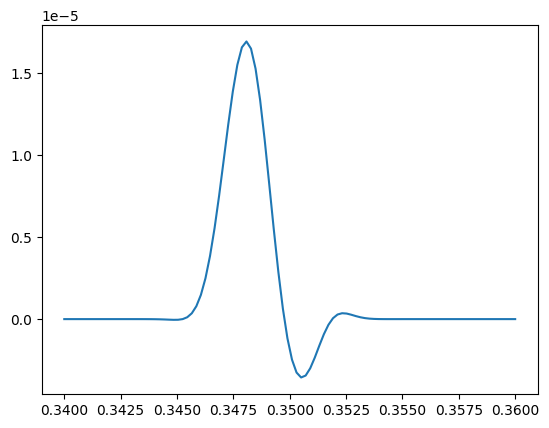

In [317]:
plt.plot(fields_t1.numpy(), spec[0, :, 12].numpy())

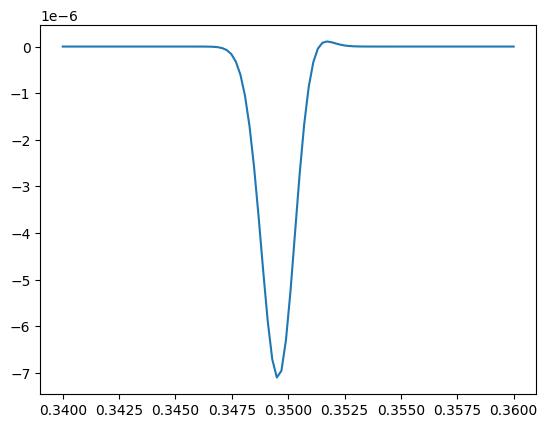

In [318]:
plt.plot(fields_t1.numpy(), spec[1, :, 12].numpy())